# Resolución de frecuencia, apodización y derrame

<div class="alert alert-block alert-warning">
Este notebook es parte de una colección de apuntes para el curso IEE2103 Señales y Sistemas, <a href="http://https://www.ing.uc.cl/electrica/">Departamento de Ingeniería Eléctrica</a>, <a href="http://www.uc.cl">Pontificia Universidad Católica de Chile</a>.<br> Profesor: <a href="http://www.rodrigocadiz.com">Rodrigo F. Cádiz</a><br>
Consultas y comentarios: <a href="mailto:rcadiz@ing.puc.cl">rcadiz@ing.puc.cl</a>

</div>

***

*** 
## $NUT=1$

Es importante determinar la relación que hay entre el intervalo de muestreo $T$ de una señal discreta, el largo $N$ de la secuencia, y el intervalo de muestreo en el dominio frecuencia, que llamaremos $U$. Como la señal ha sido muestreada con un intervalo de muestreo $T$, es claro que la máxima frecuencia contenida en la DFT es $1/T$, que corresponde a la frecuencia de muestreo. Como la DFT es de largo $N$, entonces la separación en frecuencia $U$ es 

$$ NU = \frac{1}{T} $$

es decir,

$$ \boxed{NUT = 1} $$

Esto se puede observar en el siguiente diagrama
![Relación entre el intervalo de muestreo, largo y el intervalo de muestreo de frecuencia en la DFT](images/NUT.png)

## Apodización (Windowing)

En la práctica, cuando se analiza una señal discreta física, el análisis se realiza en ventanas de tiempo de un cierto largo. Tal como hemos visto anteriormente, el largo de la ventana tiene una influencia en el espaciado temporal o frecuencial de acuerdo a la expresión $NUT = 1$. 

Para hacer el análisis, se multiplica la señal discreta por una ventana, proceso que en inglés se conoce como windowing y que en castellano denotaremos apodización, una expresión que significa "cortar los pies".

***
## Apodización

En muchos procesos de análisis de señales, no es práctico analizar señales de larga duración. Es mucho más eficiente realizar el análisis en muchas señales de menor duración y promediar o concatenar los resultados. Este proceso se realiza mediante la multiplicación de una señal discreta por una ventana, procedimiento que se conoce como apodización o *windowing* en inglés. 

Recordemos que al multiplicar por una ventana, en el dominio de Fourier se está convolucionando con la Transformada de Fourier de la ventana. Por ejemplo, si se multiplica una señal por un rect, en Fourier se está convolucionando con una señal sinc. 

En el siguiente ejemplo se muestra este caso. Una señal triangular periódica, se multiplica por una ventana rectangular para su análisis. El efecto en frecuencia es que el espectro original de la señal periódica se ve convolucionado con el espectro de la ventana rectangular.

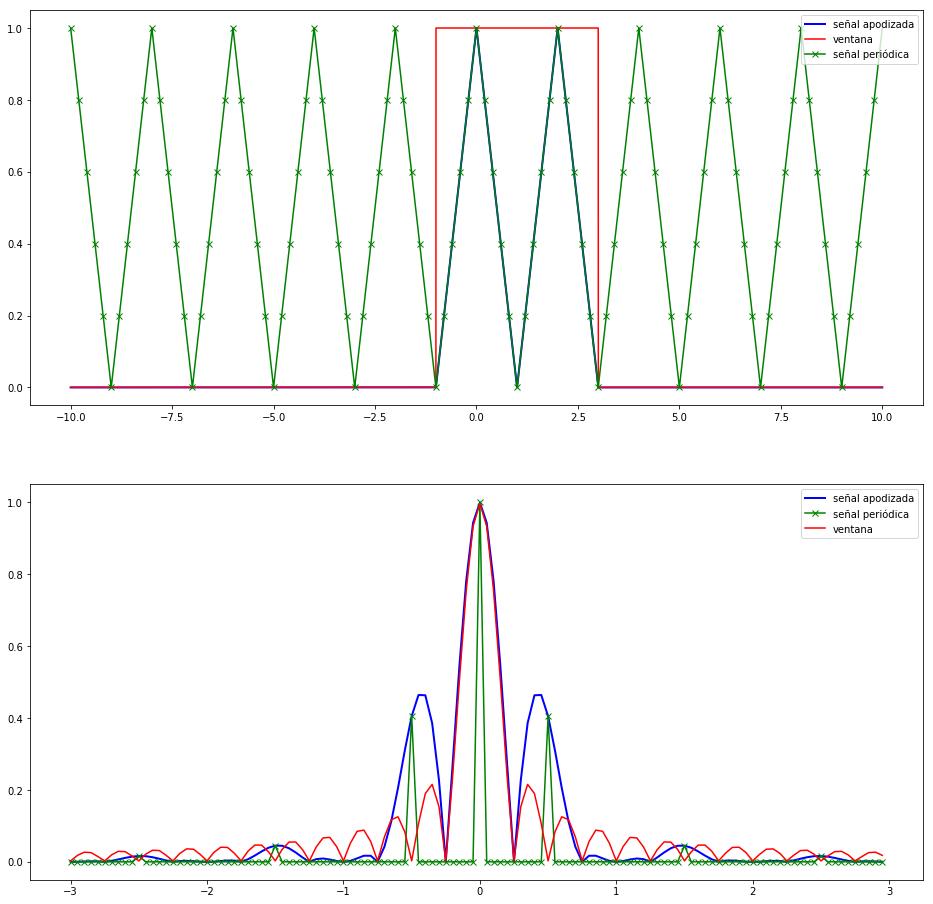

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import timeit
%matplotlib inline

def cft(g, f):
    """Numerically evaluate the Fourier Transform of g for the given frequencies"""    
    result = np.zeros(len(f), dtype=complex)
    
    # Loop over all frequencies and calculate integral value
    for i, ff in enumerate(f):
        # Evaluate the Fourier Integral for a single frequency ff, 
        # assuming the function is time-limited to abs(t)<5
        result[i] = complex_quad(lambda t: g(t)*np.exp(-2j*np.pi*ff*t), -10, 10)
    return result

def complex_quad(g, a, b):
    """Return definite integral of complex-valued g from a to b, 
    using Simpson's rule"""
    # 2501: Amount of used samples for the trapezoidal rule
    t = np.linspace(a, b, 2501)  
    x = g(t)
    return integrate.simps(y=x, x=t)

def rect(t):
    return (abs(t)<0.5).astype(float)

def triang(t):
    return (1-abs(t)) * (abs(t)<1).astype(float)

def periodic_triang(t):
    return triang(np.mod(t+1, 2)-1)

window = lambda t: rect((t-1)/4)

def windowed_periodic_triang(t):
    return periodic_triang(t) * window(t)



Fs = 10000
t = np.arange(-10, 10, 1/Fs)

f = np.arange(-3, 3, 1/20.)

cft_periodic_triang = cft(periodic_triang, f) / 10


fig = plt.figure()
fig.set_size_inches(16,16)
plt.subplot(211)
plt.plot(t, windowed_periodic_triang(t), 'b-', label='señal apodizada', lw=2);
plt.plot(t, window(t), 'r-', label='ventana')
plt.plot(t, periodic_triang(t), 'g-x', label='señal periódica', markevery=2000)
plt.legend()

cft_windowed_periodic_triang = cft(windowed_periodic_triang, f) / 2
cft_window = cft(window, f) / 4
plt.subplot(212)
plt.plot(f, abs(cft_windowed_periodic_triang), 'b-', label='señal apodizada', lw=2);
plt.plot(f, abs(cft_periodic_triang), 'g-x', label='señal periódica')
plt.plot(f, abs(cft_window), 'r-', label='ventana')

plt.legend()
plt.show()

***
## Derrame (Leaking)

Cuando el largo de la ventana escogida no coincide con el período de la señal analizada el resultado es que la información correspondiente a una frecuencia en particular no se concentra en un solo coeficiente de la DFT, sino que se derrama, un proceso que en inglés se conoce como *leaking*. En el siguiente ejemplo, se grafica la DFT de una sinusoide, cuando el largo $N$ coincide, en la fila de arriba, y cuando no coincide, en la fila de abajo, con el período de la sinusoide. Se observa que la energía, contenida en sólo dos coeficientes de la DFT en el primer caso, se derrama hacia todos los coeficientes de la DFT en el segundo.

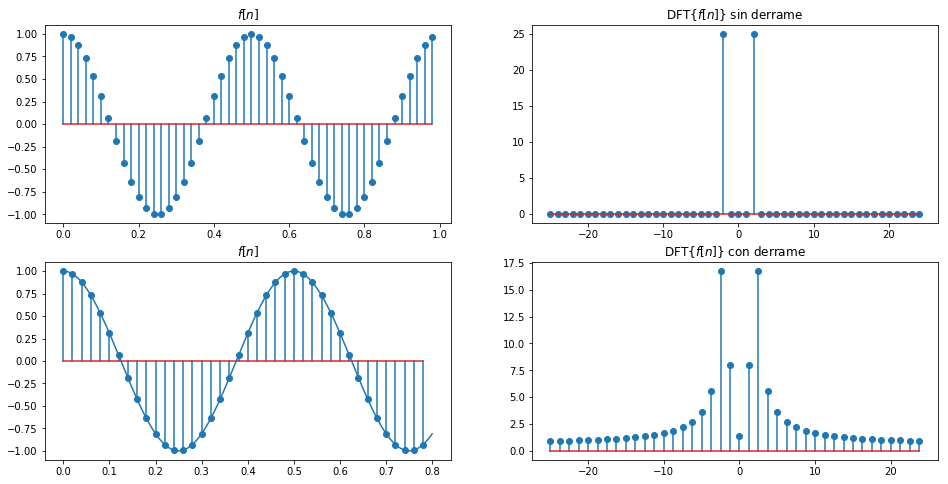

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import timeit
%matplotlib inline

def dft(xn, fftLen=None):
    if fftLen is None:
        fftLen = len(xn)
    return np.fft.fftshift(np.fft.fft(xn, fftLen))

Fs = 50 # sampling frequency
f0 = 2# signal frequency

T = 1; N = Fs*T
t = np.arange(0, T, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/N)  # the frequency bin axis

cos_t = np.cos(2*np.pi*f0*t)

fig = plt.figure()
fig.set_size_inches(16,8)

plt.subplot(221)
plt.stem(t, cos_t);
plt.title('$f[n]$')

plt.subplot(222)
plt.stem(f, abs(dft(cos_t)))
plt.title('DFT$\{f[n]\}$ sin derrame')

T = 0.8;
t = np.arange(0, T, 1/Fs)  # the time samples
N = len(t)

f = np.arange(-Fs/2, Fs/2, Fs/N)  # the frequency bin axis

cos_t = np.cos(2*np.pi*f0*t)

t_fine = np.arange(0, T, 1/(100*Fs))
t_long = np.arange(-1, 2, 1/Fs) 

cos_tfine = np.cos(2*np.pi*f0*t_fine)

plt.subplot(223)
plt.stem(t, cos_t)
plt.plot(t_fine, cos_tfine)
plt.title('$f[n]$')

plt.subplot(224)
plt.stem(f, abs(dft(cos_t)))
plt.title('DFT$\{f[n]\}$ con derrame')

plt.show()

<div class="alert alert-block alert-warning">
<b>Copyright</b><br>

Estos apuntes están licenciados bajo la licencia <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0</a>.<br>
Como citar: <i>Rodrigo F. Cádiz, Apuntes de Señales y Sistemas.</i>
</div>